In [98]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import random
import os

# YOU NEED TO GO TO THE paths.py FILE AND PUT YOUR FOLDER OF IMAGES in the CAR_IMAGES_DIR variable
from paths import FRONTAL, LATERAL


#INDIVIDUAL_IMG_PATHS = [CAR_IMAGES_DIR / image_name for image_name 
#                        in os.listdir(CAR_IMAGES_DIR)]

FRONTALIMAGES = [str(FRONTAL / image_name) for image_name 
                        in os.listdir(FRONTAL)]

LATERALIMAGES = [str(LATERAL / image_name) for image_name 
                        in os.listdir(LATERAL)]

## Utils functions for plotting

In [21]:
#FUNCTIONS FOR PLOTTING VARIOS RESULTS
def plot_binary_methods():
    plt.figure(figsize=(15, 10))   # (width, height)
    methods = ['original', 'simple', 'adaptive', 'otsu', 'Gaus_otsu']
    
    for i in range(len(methods) * 3):
        pos = i % len(methods)
        if (pos == 0):
            image_path = random.choice(INDIVIDUAL_IMG_PATHS)
            
        image = binary_methods(image_path, method=methods[pos])
        plt.subplot(3, len(methods), i+1)
        plt.imshow(image, 'gray')
        plt.title(methods[pos])
        plt.xticks([]),plt.yticks([])
    
    plt.show()

def plot_mhorp_methods():
    plt.figure(figsize=(15, 10))   # (width, height)
    methods = ['original', 'dilation', 'erosion', 'opening', 'closing']
    
    for i in range(len(methods) * 3):
        pos = i % len(methods)
        if (pos == 0):
            image_path = random.choice(INDIVIDUAL_IMG_PATHS)
        
        binary_image = binary_methods(image_path, method = 'simple')
        output = mhorp_operations(binary_image, method = methods[pos], image_path=image_path)
        plt.subplot(3, len(methods), i+1)
        plt.imshow(output, 'gray')
        plt.title(methods[pos])
        plt.xticks([]),plt.yticks([])
    
    plt.show()

## Preprocessing of the images

In [56]:
#Function for appyling the binarization methods
def binary_methods(image_gray, method = 'simple'):
    #if method == 'original':
    #return image_rgb
    if method == 'simple':
        binary__image = cv.threshold(image_gray, 127, 255, 0)[1]

    elif method == 'adaptive':
        binary__image = cv.adaptiveThreshold(image_gray, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2)

    elif method == 'otsu':
        _, binary__image = cv.threshold(image_gray, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)

    return binary__image

#Function for applying the mhorpological operations
def mhorp_operations(binary_image, method = 'dilation', image_path = None):
    kernel = np.ones((4,10),np.uint8)
    
    if method == 'original':
        image = cv.imread(str(image_path))
        image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        return image_rgb
    
    if method == 'dilation':
        result = cv.dilate(binary_image, kernel, iterations = 1)

    elif method == 'erosion':
        result = cv.erode(binary_image, kernel, iterations = 1)

    elif method == 'opening':
        result = cv.morphologyEx(binary_image, cv.MORPH_OPEN, kernel)

    elif method == 'closing':
        result = cv.morphologyEx(binary_image, cv.MORPH_CLOSE, kernel)
        result = cv.morphologyEx(result, cv.MORPH_CLOSE, kernel)

    return result

# FUNCTION USED TO PREPROCESS A GIVEN IMAGE
def preprocess_image_1(image_path):
    #Open the image, and pass it from BGR to RGB
    image = cv.imread(image_path)
    image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    #Pass the image to gray scale. Apply also gaussian blur to reduce noise in the image
    image_gray = cv.cvtColor(image_rgb, cv.COLOR_RGB2GRAY)
    image_gray = cv.GaussianBlur(image_gray, (5, 5), 0)

    #Binarization doing one of the possible methods
    binary_image = binary_methods(image_gray, method='otsu')

    #Apply Mhorpological operations to the image using one of the possbile methods
    mhorp_image = mhorp_operations(binary_image, method = 'closing') 

    return mhorp_image  

# FUNCTION USED TO PREPROCESS A GIVEN IMAGE
def hsv_preprocess_image(image_path):
    #Open the image, and pass it from BGR to RGB
    image = cv.imread(image_path)
    image_hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    saturation = cv.split(image_hsv)[1]
    #Pass the image to gray scale. Apply also gaussian blur to reduce noise in the image
    #image_gray = cv.GaussianBlur(saturtion, (3, 3), 0)

    #Binarization doing one of the possible methods
    binary_image = binary_methods(saturation, method='simple')

    #Apply Mhorpological operations to the image using one of the possbile methods
    mhorp_image = mhorp_operations(binary_image, method = 'opening') 

    return mhorp_image  

## Rectangle detection

### Method_1: Contour Approximation

In [24]:
import cv2
import numpy as np
import imutils
#import easyocr

def preprocess_image(img_path):
    """Preprocess the image and return required intermediates."""
    # Read the image
    img = cv2.imread(img_path)
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Noise reduction using bilateral filter
    bfilter = cv2.bilateralFilter(gray, 11, 17, 17)
    # Edge detection using Canny
    edged = cv2.Canny(bfilter, 30, 200)
    return img, gray, edged

def find_license_plate_contour(edged):
    """Find and return the contour of the license plate."""
    # Find contours in the edge-detected image
    keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(keypoints)
    # Sort contours based on area and keep the top 10
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
    # Try finding a contour that resembles a license plate (4 corners)
    for contour in contours:
        approx = cv2.approxPolyDP(contour, 10, True)
        if len(approx) == 4:
            return approx    
    return None

def extract_text_from_plate(img, gray, location):
    """Extract text from the detected license plate and annotate the original image."""
    mask = np.zeros(gray.shape, np.uint8)
    cv2.drawContours(mask, [location], 0, 255, -1)
    cv2.bitwise_and(img, img, mask=mask)
    (x, y) = np.where(mask==255)
    (x1, y1) = (np.min(x), np.min(y))
    (x2, y2) = (np.max(x), np.max(y))
    cropped_image = gray[x1:x2+1, y1:y2+1]

    reader = easyocr.Reader(['en'])
    result = reader.readtext(cropped_image)
    if (len(result) == 0):
        text = ""
    else:
        text = result[0][-2].upper()

    # Annotate the original image
    font = cv2.FONT_HERSHEY_SIMPLEX
    res = cv2.putText(img, text=text, org=(location[0][0][0], location[1][0][1]+60), fontFace=font, fontScale=1, color=(0,255,0), thickness=2, lineType=cv2.LINE_AA)
    res = cv2.rectangle(img, tuple(location[0][0]), tuple(location[2][0]), (0,255,0),3)
    return res

# Main method to process the image and visualize the results
def method1_contour_approximation(img_path):
    img, gray, edged = preprocess_image(img_path)
    location = find_license_plate_contour(edged)
    if location is None:
        print("Sorry, license plate not detected.")
        return
    result_img = extract_text_from_plate(img, gray, location)
    plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    plt.show()

### Method_2: Contours detection and SVM classification

In [41]:
def find_license_plate_aspect_ratio(edged):
    """Find and return the contour of the license plate."""
    # Find contours in the edge-detected image
    keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(keypoints)

    good_contours = []
    height, width = edged.shape
    # Calculating buffer in terms of pixels
    border_buffer_x = width * 0.2
    border_buffer_y = height * 0.2
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        # Check if the contour is inside the buffered region
        if (x > border_buffer_x) and (x + w < width - border_buffer_x) and \
           (y > border_buffer_y) and (y + h < height - border_buffer_y):
                aspect_ratio = float(w) / h
                if (1.2 < aspect_ratio < 8):
                    good_contours.append(contour)
    good_contours = sorted(good_contours, key=cv2.contourArea, reverse=True)[:200]
    return None if len(good_contours) == 0 else good_contours

def extract_patch_from_image(img, gray, locations):
    cropped_images = []

    for location in (locations):
        mask = np.zeros(gray.shape, np.uint8)
        cv2.drawContours(mask, [location], 0, 255, -1)
        cv2.bitwise_and(img, img, mask=mask)
        (x, y) = np.where(mask==255)
        (x1, y1) = (np.min(x), np.min(y))
        (x2, y2) = (np.max(x), np.max(y))
        cropped_image = gray[x1:x2+1, y1:y2+1]
        cropped_images.append(cropped_image)
    return cropped_images

# Main method to process the image and visualize the results
def method_3(img_path):
    img, gray, edged = preprocess_image(img_path)
    locations = find_license_plate_aspect_ratio(edged)
    if locations is None:
        print("Sorry, license plate not detected.")
        return
    cropped_images = extract_patch_from_image(img, gray, locations)
    return cropped_images
    #return img, locations # Returns the contours that SVM needs to classify

In [104]:
cropped_images = method_3(LATERALIMAGES[6])

In [134]:
png_files[7]

'D:\\NIL\\Uni\\licensplates\\images\\N106.jpeg'

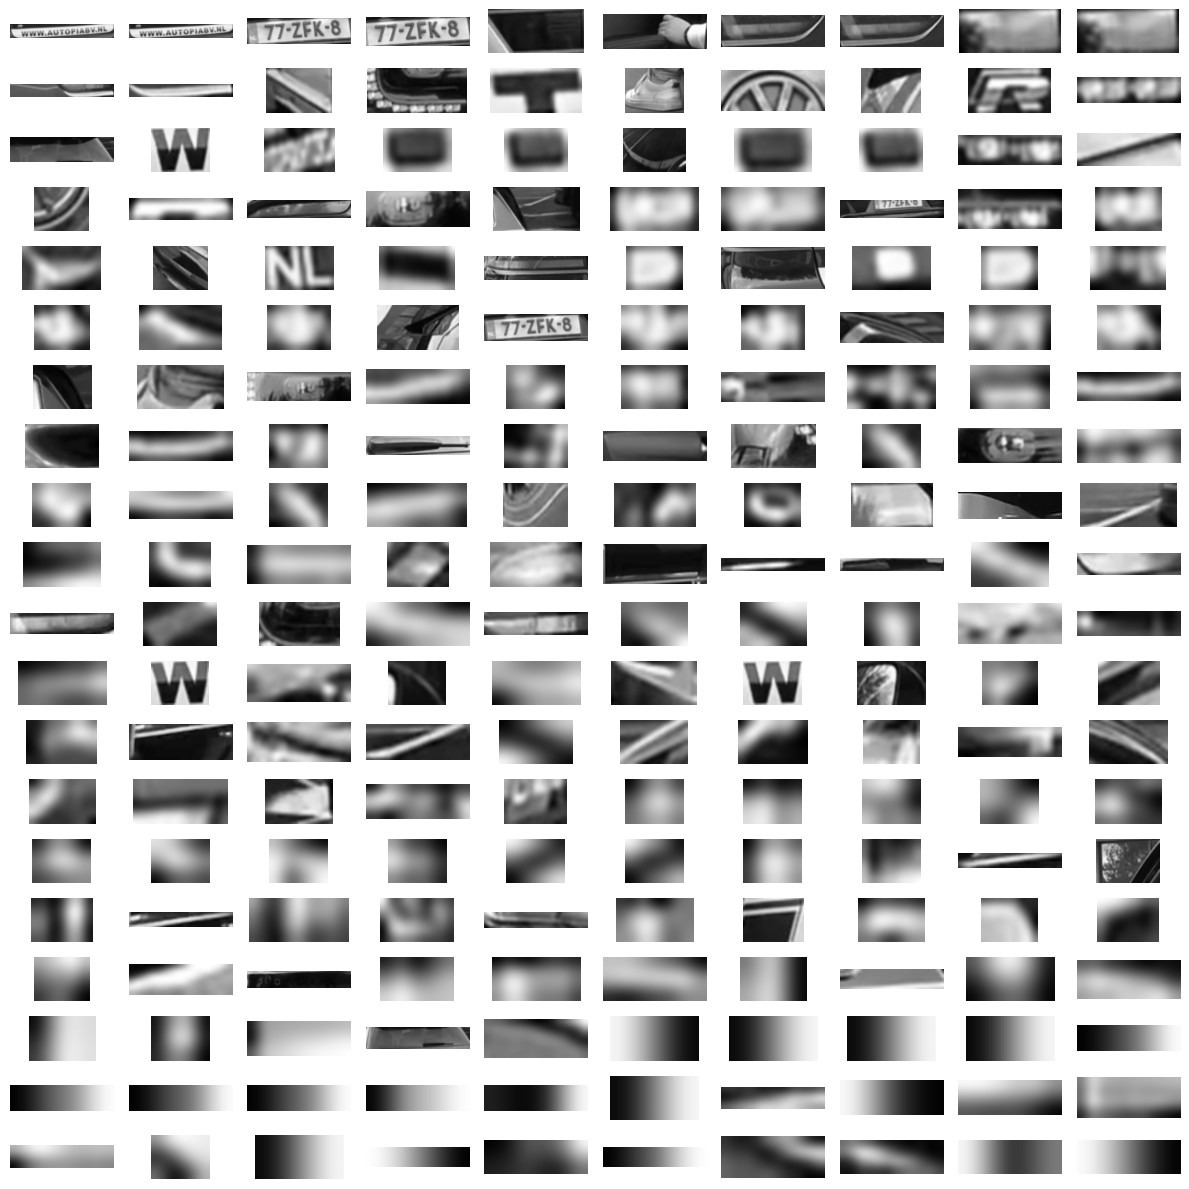

In [146]:
import matplotlib.pyplot as plt
cropped_images = method_3(png_files[0])
# Assuming cropped_images is a list of images

# Set the figure size to make subplots larger
fig = plt.figure(figsize=(12, 12))

# Create a 10x10 grid of subplots
for i, image in enumerate(cropped_images[:200], start=1):
    plt.subplot(20, 10, i)
    
    # Adjust the aspect ratio to prevent stretching
    plt.gca().set_aspect('equal', adjustable='box')
    
    # You can adjust the size of the image by setting the interpolation
    plt.imshow(image, cmap='gray', interpolation='bicubic')
    
    plt.axis('off')  # Optional: Hide axis labels

plt.tight_layout()
plt.show()


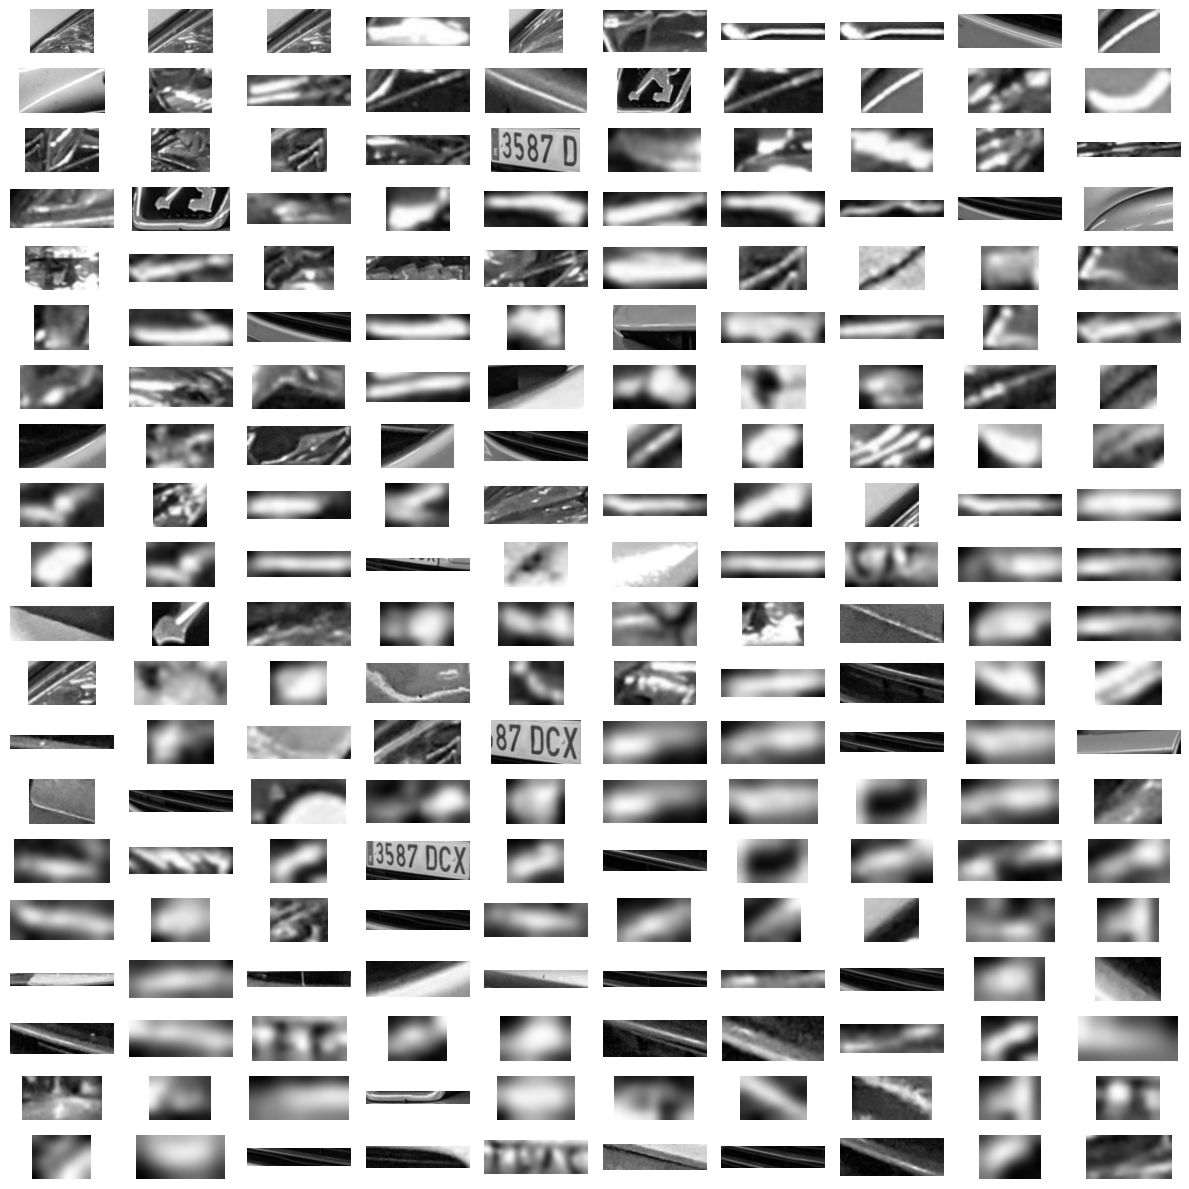

In [144]:
import matplotlib.pyplot as plt
cropped_images = method_3(LATERALIMAGES[6])
# Assuming cropped_images is a list of images

# Set the figure size to make subplots larger
fig = plt.figure(figsize=(12, 12))

# Create a 10x10 grid of subplots
for i, image in enumerate(cropped_images[:200], start=1):
    plt.subplot(20, 10, i)
    
    # Adjust the aspect ratio to prevent stretching
    plt.gca().set_aspect('equal', adjustable='box')
    
    # You can adjust the size of the image by setting the interpolation
    plt.imshow(image, cmap='gray', interpolation='bicubic')
    
    plt.axis('off')  # Optional: Hide axis labels

plt.tight_layout()
plt.show()


In [ ]:
# List of lists which will be translated to the csv file
dataset_annotations = list()

# Iteration over all the images
for img_num, img_path in enumerate(INDIVIDUAL_IMG_PATHS):

    #Contours of the image
    image_org = cv.imread(str(INDIVIDUAL_IMG_PATHS[img_num]))
    image_org = cv.cvtColor(image_org, cv.COLOR_BGR2RGB)
    cnts = method_3(str(INDIVIDUAL_IMG_PATHS[img_num]))

    # x, y, w, h, 0-1 for each cropped image. Whole information about all the detected rectangles on an image
    main_image = list()

    # First element on the list is the naming of the particular image
    main_image.append("Image" + str(img_num))

    # Iterate through contours and draw filled rectangles on the mask
    for c in cnts:
               # List for a single crop of the actual image
        crop = list()

        # Take the coordinates of the rectangle
        x, y, w, h = cv.boundingRect(c)
        # Append coordinates
        crop.append(x)
        crop.append(y)
        crop.append(w)
        crop.append(h)

        # Crop the image using the coordinates x, y, w, and h
        cropped_image = image_org[y:y+h, x:x+w]

        # Display the cropped image
        cv.imshow('Cropped Image', cropped_image)
        cv.waitKey(0)
        cv.destroyAllWindows()

        """ | Control system to introduce a correct input | """

        # Initialization of the boolean
        license_bool = int(input("(0 or 1) License? "))

        while (license_bool != (1 or 0)):

            # Set the boolean value of being a license to True or False. 0 || 1
            license_bool = int(input("Incorrect! (0 or 1) License? "))

        """ | Control system to introduce a correct input | """

        # Append boolean information about license existance
        crop.append(license_bool)

        # Append the information about the rectangle to the main image list
        main_image.append(crop)

        # If the license is already detected stop the finding process for that particular image
        if (license_bool == 1):
            break

    # Append the main image to the dataset annotations in order to eventually pass it to the csv file
    dataset_annotations.append(main_image)

# Create the CSV file
with open('image_annotations.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(dataset_annotations)

In [39]:
img, loc = method_3(path)

In [41]:
img

(2268, 4032, 3)

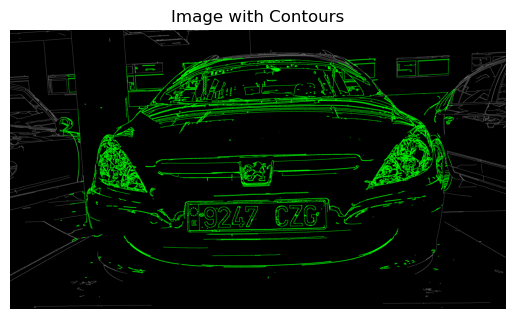

In [25]:
path = str(FRONTALIMAGES[13])
img, loc = method_3(path)

image_with_contours = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)  # Ensure it's a BGR image

# Draw the contours on the image
cv2.drawContours(image_with_contours, loc, -1, (0, 255, 0), 2)

# Check if any contours were found
if loc:
    # Convert the image to RGB format (for plotting with matplotlib)
    image_with_contours_rgb = cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB)

    # Plot the image with contours using matplotlib
    plt.imshow(image_with_contours_rgb)
    plt.axis('off')
    plt.title('Image with Contours')
    plt.show()
else:
    print("No contours found.")

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from os import walk

import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split

In [109]:
cropped_images = method_3(LATERALIMAGES[6])

In [125]:
from sklearn import svm
import xml.etree.ElementTree as ET
from paths import DATASET_IMG, FRONTAL, LATERAL

xml_files, png_files = [], []
for file in os.listdir(DATASET_IMG):
    xml_files.append(str(DATASET_IMG / file)) if file.endswith('.xml') else png_files.append(str(DATASET_IMG / file))

samples = []
for image_path, xml_path in zip(png_files, xml_files):
    img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    # Load XML from file
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    # Extract bounding box
    bndbox = root.find('.//bndbox')
    xmin = int(bndbox.find('xmin').text)
    ymin = int(bndbox.find('ymin').text)
    xmax = int(bndbox.find('xmax').text)
    ymax = int(bndbox.find('ymax').text)
    licenseplate = img[ymin:ymax, xmin:xmax]

    shape = licenseplate.shape
    if not 0 in shape:
        samples.append(licenseplate)



In [126]:
png_files[0]

'D:\\NIL\\Uni\\licensplates\\images\\N1.jpeg'

In [118]:
def obtain_sift_features(gray_licensplates): # All the images are not gray
    sift = cv2.SIFT_create()
    sift_features = []

    sift_features =  list(map(lambda gray_image: sift.detectAndCompute(gray_image, None)[1], gray_licensplates))
    
    sift_features = filter(lambda image_path: image_path is not None, sift_features)
    sift_features = list(map(lambda features: features.sum(0), sift_features))

    sift_features = np.vstack(sift_features)


    return sift_features

In [108]:
sift_features = obtain_sift_features(samples)

In [116]:
X_train = sift_features
y_train = np.ones(X_train.shape[0])
y_train[0] = 0

clf = svm.SVC(kernel='rbf', C=1.0)
clf.fit(X_train, y_train)

SVC()

In [120]:
features_images = obtain_sift_features(cropped_images)

In [140]:
features_images[2]

array([ 3081.,  1304.,   797.,  2155.,  5173.,  1257.,   405.,   548.,
        8761.,  1988.,   755.,  1283.,  3456.,  1138.,   658.,  1802.,
        9055.,  1705.,   495.,  1081.,  5302.,  1557.,  1077.,  2469.,
        3975.,  1351.,   520.,  1205.,  6284.,  2076.,   662.,  1357.,
        4399.,  1326.,   834.,  2235.,  5981.,  1629.,   525.,   805.,
       11544.,  1921.,   669.,  1055.,  3642.,  1519.,  1189.,  3282.,
       10415.,  1938.,   385.,  1394.,  6943.,  2991.,  1567.,  2829.,
        4692.,  1504.,   542.,  1532.,  7349.,  2797.,   827.,  1639.,
        4665.,  1383.,   730.,  1967.,  6023.,  2060.,   678.,   936.,
       11598.,  3337.,  1015.,  1171.,  3557.,  1301.,   725.,  2448.,
       10466.,  2631.,  1010.,  2513.,  6735.,  1595.,   540.,  2382.,
        5213.,  1419.,   497.,  1763.,  7207.,  2242.,   630.,  1857.,
        3580.,  1001.,   473.,  1467.,  5192.,  1558.,   662.,  1126.,
        9302.,  2330.,   696.,   934.,  2898.,  1200.,   754.,  2223.,
      

In [124]:
clf.predict(features_images)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.])

In [122]:
features_images.shape

(155, 128)